In [1]:
"""
In this notebook , I try m -> n sequence generation with crossentropy.
Just changed the architecture:
Change the loss function
and Logsoftmax is not applied for last layer.

my alphabet has 5 letters "abcde"
I create a sequence of 6 letters and output most occuring 2 letters.

input  = ['a', 'b', 'a', 'd', 'b', 'a']
output = ['a', 'b']

1st is most occuring letter
2ns is second most occuring.
In eval method  i both measure, any match of sequence
and full match of sequence.


"""
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

torch.manual_seed(1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#My utility to log intermediate steps
class StepLogger():
    def __init__(self,capacity):
        self.tensor_datas = {}        
        self.capacity = capacity
        self.added_labels = []
        
    
    def add_info(self,tensor_data,tensor_label):
        if tensor_label not in self.added_labels:
            self.added_labels.append( tensor_label )
        
        if tensor_label in self.tensor_datas.keys():
            current_arr = self.tensor_datas.get(tensor_label)
            if len(current_arr) < self.capacity:
                current_arr = self.tensor_datas.get(tensor_label, [])
                current_arr.append(tensor_data)
        else:
            self.tensor_datas[tensor_label] = [tensor_data]
    
    def get_default_summary(self,show_data=False,summary_count=1):
        self.get_summary(self.added_labels,show_data)
        
    def get_summary(self,labels,show_data=False,summary_count=1):
        count = 0
        for i in range(summary_count):
            for l in labels:
                label_data = self.tensor_datas.get(l)[count]
                print(l)
                if torch.is_tensor(label_data):
                    print( list(label_data.size() ) )
                if not show_data and not torch.is_tensor(label_data):
                    print(label_data)
                if show_data:    
                    print(label_data)

In [3]:
#data generation methods
all_letters = "abcde"


def prepare_sequence(name):
    rep = np.zeros( (len(name), 1) )
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0] = pos
    return rep

def gen_1_tuple():
    seq_len = 3
    template = [1,1,2,2,3,3,4,4,5,5]
    sequence = random.sample(template,3)
    b = {}
    for item in sequence:
        #only count smaller than 10
        if item < 10:
            b[item] = b.get(item, 0) + 1    
    sb = sorted(b.items(), key=lambda x: x[1],reverse=True)   
    most_occur = 1
    most_occur_2 = 1
    try:
        most_occur   = sb[0][0]
        
        most_occur_2 = sb[1][0]
    except Exception as ex:
        print("sb ",b)
        most_occur = 1
        
            
    result_list = sequence+[most_occur,most_occur,most_occur_2] 
    result_list = random.sample(result_list,len(result_list))
    to_word = [all_letters[i-1] for i in result_list ]
    return to_word,[all_letters[most_occur-1],all_letters[most_occur_2-1] ]

def nat_rep(data_index):
    return np.array([all_letters.index(i)for i in data_index])

def gen_data_tuple():
    d1 = gen_1_tuple()
    return d1    
    
d = gen_data_tuple()
print(d)
nat_rep(d[1])
#seq_rep(d[0])
db = gen_data_tuple()
print(db)
print(len(db[0]))
print(nat_rep(db[1]))

(['a', 'a', 'b', 'd', 'b', 'b'], ['b', 'a'])
(['e', 'c', 'b', 'e', 'e', 'c'], ['e', 'c'])
6
[4 2]


In [4]:
trains = [ gen_data_tuple() for _ in range(2000)]
X_train = [t[0] for t in trains ]
y_train = [t[1] for t in trains ]

tests = [ gen_data_tuple() for _ in range(200)]
X_test = [t[0] for t in tests ]
y_test = [t[1] for t in tests ]

In [5]:
print("data " ," ".join(X_train[0]) )
print("label " ,y_train[0] )

print("data " ,prepare_sequence(X_train[0]) )
print("label " ,prepare_sequence(y_train[0]) )

data  e c b c c b
label  ['c', 'b']
data  [[4.]
 [2.]
 [1.]
 [2.]
 [2.]
 [1.]]
label  [[2.]
 [1.]]


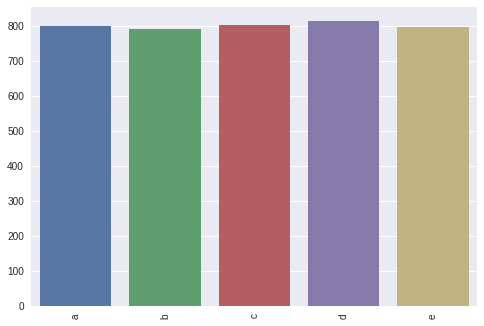

In [6]:
#check distribution of data
count = {}
for l in all_letters:
    count[l] = 0

for d in trains:
    count[d[1][0]] += 1
    count[d[1][1]] += 1

#plot the distribution
plt.style.use("seaborn")
plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(), rotation = 90)
plt.show()   

In [11]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)        

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size * 2)
        
        #self.softAct = nn.Softmax(dim=1)
    
    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_dim), torch.zeros(1, 1, self.hidden_dim))

    def forward(self, sentence):
        step_logger.add_info(sentence,"forward sentence")
        
        embeds = self.word_embeddings(sentence)
        step_logger.add_info(embeds,"forward embeds")
        
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        step_logger.add_info(lstm_out,"forward lstm_out")
                
        last_layer =  lstm_out[-1]
        step_logger.add_info(last_layer,"forward last_layer")

        tag_space =  self.hidden2tag(last_layer)
        step_logger.add_info(tag_space,"forward tag_space")

        tag_view = tag_space.view(2, -1)
        step_logger.add_info(tag_view,"forward tag_view")        
        
        #tag_scores = F.log_softmax(tag_view)
        #step_logger.add_info(tag_scores,"forward tag_scores")
        
        return tag_view

In [12]:
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

def eval(model_,   X_, y_,full_match):
     
     correct = 0
     #model_.eval()
     
     for index in range(len(X_)):
         test_input = X_[index]
         test_output = y_[index]
         
         actuals,expecteds,score = infer( model_, test_input,test_output,full_match)
         correct += score
         
     #print("  correct",correct,"len(X_) ",len(X_))       
     accuracy = 0                   
     if full_match : 
       accuracy = (correct * 100 ) /len(X_)
     else:  
       accuracy = ( correct * 100 ) / ( len(X_) * 2) #we are counting partial match as partial success
     return accuracy

  

def infer(model_,test_input,test_output,full_match):
  
  name_ohe = prepare_sequence(test_input)
  
  t = torch.tensor(name_ohe, dtype = torch.long)

  tag_scores = model_(t)  
  val, indices = tag_scores.topk(1)

  actuals = indices.squeeze().numpy()
  expecteds = prepare_sequence(test_output).flatten().astype(int)
  #print("actuals ",actuals," expecteds ",expecteds)
  score =0
  if full_match :
    score = int( actuals[0] == expecteds[0] and actuals[1] == expecteds[1])
  else :
    score = int(actuals[0] == expecteds[0]) + int(actuals[1] == expecteds[1])

  return actuals,expecteds,score

def train_epoch(shuffled,optimizer):
  last_loss = 0
  for sentence, tags in shuffled:
    # Step 1. Remember that Pytorch accumulates gradients.
    # We need to clear them out before each instance
    model.zero_grad()
    #print("pass")
    # Step 2. Get our inputs ready for the network, that is, turn them into
    # Tensors of word indices.
    #print("tags",tags)
    
    sentence_in = torch.tensor(prepare_sequence(sentence), dtype=torch.long) 
    targets = torch.tensor(prepare_sequence(tags), dtype=torch.long )  
            
    step_logger.add_info(sentence_in,"train sentence_in")

    # Step 3. Run our forward pass.
    tag_scores = model(sentence_in)

    # Step 4. Compute the loss, gradients, and update the parameters by
    #  calling optimizer.step()
    
    step_logger.add_info(tag_scores.squeeze(),"train tag_scores")
    step_logger.add_info(targets,"train targets")
    
    loss = loss_function(tag_scores.squeeze(), targets.squeeze())
    loss.backward()
    optimizer.step()  
    last_loss = loss
  return last_loss

In [13]:
#definition of model
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, 5, 5)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
torch.autograd.set_detect_anomaly(True)

step_logger =  StepLogger(2)
training_data = zip(X_train,y_train)
tranlist = list(training_data)

In [14]:
import timeit


for epoch in range(21): 
    start_time = timeit.default_timer() # again, normally you would NOT do 300 epochs, it is toy data
    #print("\n\n","epoch",epoch)
    if epoch % 2 == 1:
      #tests = [ gen_data_tuple() for _ in range(200)]
      with torch.no_grad() :
        #clear_output(wait = True)
        print("--------------------")
        print(epoch ,"   Epoch Full sequence ", round(eval(model,  X_test, y_test,True),2) )
        print(epoch ,"   Epoch Partial       " ,round(eval(model,  X_test, y_test,False),2) )

    
    shuffled = tranlist #random.sample(tranlist, len(tranlist))  
     
    #model.train()
    #with torch.grad():
    epoch_loss = train_epoch(shuffled,optimizer)    
    elapsed = timeit.default_timer() - start_time    
    #print(epoch," elapsed ",elapsed," epoch_loss ",epoch_loss)
    
    

--------------------
1    Epoch Full sequence  60.0
1    Epoch Partial        78.5
--------------------
3    Epoch Full sequence  78.0
3    Epoch Partial        88.75
--------------------
5    Epoch Full sequence  85.0
5    Epoch Partial        92.25
--------------------
7    Epoch Full sequence  91.5
7    Epoch Partial        95.75
--------------------
9    Epoch Full sequence  92.0
9    Epoch Partial        96.0
--------------------
11    Epoch Full sequence  93.5
11    Epoch Partial        96.5
--------------------
13    Epoch Full sequence  94.0
13    Epoch Partial        97.0
--------------------
15    Epoch Full sequence  87.0
15    Epoch Partial        93.0
--------------------
17    Epoch Full sequence  96.5
17    Epoch Partial        98.0
--------------------
19    Epoch Full sequence  97.0
19    Epoch Partial        98.25


In [15]:
#check intermediate object shapes
step_logger.get_default_summary()

train sentence_in
[6, 1]
forward sentence
[6, 1]
forward embeds
[6, 1, 6]
forward lstm_out
[6, 1, 6]
forward last_layer
[1, 6]
forward tag_space
[1, 10]
forward tag_view
[2, 5]
train tag_scores
[2, 5]
train targets
[2, 1]


In [16]:
#check intermediate object samples
step_logger.get_default_summary(True)

train sentence_in
[6, 1]
tensor([[4],
        [2],
        [1],
        [2],
        [2],
        [1]])
forward sentence
[6, 1]
tensor([[4],
        [2],
        [1],
        [2],
        [2],
        [1]])
forward embeds
[6, 1, 6]
tensor([[[-2.1984,  0.2861, -0.2010, -2.5349, -1.3196,  1.6485]],

        [[ 0.2693, -0.4886, -0.5606, -0.6555,  0.7262,  0.6789]],

        [[ 1.0757, -0.5536, -3.2686,  0.4750, -2.1142, -1.5002]],

        [[ 0.2693, -0.4886, -0.5606, -0.6555,  0.7262,  0.6789]],

        [[ 0.2693, -0.4886, -0.5606, -0.6555,  0.7262,  0.6789]],

        [[ 1.0757, -0.5536, -3.2686,  0.4750, -2.1142, -1.5002]]],
       grad_fn=<EmbeddingBackward>)
forward lstm_out
[6, 1, 6]
tensor([[[-0.0047, -0.0221,  0.1305, -0.2407,  0.1358, -0.1925]],

        [[ 0.0115,  0.0516,  0.1428, -0.1114,  0.1675, -0.1921]],

        [[ 0.3817, -0.0492, -0.0840, -0.1207, -0.0196, -0.1366]],

        [[ 0.1550,  0.0110, -0.0656, -0.0381,  0.0800, -0.1663]],

        [[ 0.1066,  0.0749, -0.0184

In [17]:
#test some samples
for index_ in range(10):
  print(X_test[index_],y_test[index_])
  a,b,c = infer( model, X_test[index_],y_test[index_],False)
  print( a,b,c)
  a,b,c = infer( model, X_test[index_],y_test[index_],True)
  print( a,b,c)

['d', 'c', 'd', 'a', 'c', 'c'] ['c', 'd']
[2 3] [2 3] 2
[2 3] [2 3] 1
['c', 'a', 'd', 'a', 'c', 'a'] ['a', 'c']
[0 2] [0 2] 2
[0 2] [0 2] 1
['d', 'b', 'b', 'd', 'a', 'b'] ['b', 'd']
[1 3] [1 3] 2
[1 3] [1 3] 1
['a', 'e', 'e', 'b', 'e', 'b'] ['e', 'b']
[4 1] [4 1] 2
[4 1] [4 1] 1
['a', 'a', 'a', 'e', 'e', 'a'] ['a', 'e']
[0 4] [0 4] 2
[0 4] [0 4] 1
['d', 'd', 'd', 'd', 'b', 'b'] ['d', 'b']
[3 1] [3 1] 2
[3 1] [3 1] 1
['c', 'a', 'b', 'b', 'c', 'b'] ['b', 'c']
[1 2] [1 2] 2
[1 2] [1 2] 1
['e', 'a', 'a', 'a', 'e', 'a'] ['a', 'e']
[0 4] [0 4] 2
[0 4] [0 4] 1
['e', 'e', 'e', 'c', 'b', 'c'] ['e', 'c']
[4 2] [4 2] 2
[4 2] [4 2] 1
['e', 'd', 'c', 'e', 'e', 'c'] ['e', 'c']
[4 2] [4 2] 2
[4 2] [4 2] 1
